# Lab 8: Sequential VAEs

In this lab we will build a very simple version of of [**LFADS: Latent Factor Analysis for Dynamical Systems**](https://www.nature.com/articles/s41592-018-0109-9) (Pandarinath et al, 2018). LFADS is a popular technique for for modeling neural spike train data, finding low-dimensional factors of variation, and studying their nonlinear dynamics. 

Technically, LFADS is a sequential variational autoencoder (VAE). Like all VAEs, it consists of two parts:
1. A **generative model** that can sample new sequences of latent variables and from them produce new spike trains.
2. An **encoder** that takes in spike trains and produces a distribution over latent variables that produced them.

In LFADS, both the generator and the encoder and implemented with **recurrent neural networks (RNNs)**. Once trained, we can study the dynamics learned by these RNNs and use the inputs necessary to drive them to produce realistic neural data.

**References**

- Pandarinath, Chethan, et al. "Inferring single-trial neural population dynamics using sequential auto-encoders." Nature methods 15.10 (2018): 805-815.

## Setup

In [1]:
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Poisson, Uniform, kl_divergence
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

## Part 0: Make some synthetic data

We'll start by simulating data from a simple oscillatory system with sparse "kicks" to the state. There are two underlying oscillators, $\theta_0$ and $\theta_1$, with different angular velocities (rates), $\dot{\theta}_0$ and $\dot{\theta}_1$. Each _trial_ starts in the same initial condition, $\theta_0 = \theta_1 = 0$, but then the oscillators receive random inputs $u_t \sim \mathrm{Unif}([0, 2 \pi))$. Importantly, both oscillators receive the same kicks! The resulting dynamics are,

$$
\theta_{d,t} = \theta_{d,t-1} + \dot{\theta}_d + u_t.
$$

for $d \in \{0,1\}$.

The neural spike trains are simulated as linear functions of the sine and cosine of the oscillators,

$$
\begin{align*}
y_{n,t} &\sim \mathrm{Po}(f(\mathbf{w}_n^\top \mathbf{x}_t + b_n)) \\
\mathbf{x}_t &= [\cos(\theta_0), \sin(\theta_0), \cos(\theta_1), \sin(\theta_1)]^\top. 
\end{align*}
$$

In [2]:
rate0 = 2 * torch.pi / 20.0
# rate1 = 1.4142 * 2 * torch.pi / 20.0
rate1 = 2 * rate0

def sample_trial(weights, bias,
                 num_timesteps=100,
                 rate0=rate0,
                 rate1=rate1,
                 kick_prob=0.05):
    """Sample a single trial of data according to the model above.
    """
    theta = torch.zeros(num_timesteps, 2)
    u = torch.zeros(num_timesteps, 1)
    for t in range(1, num_timesteps):
        if torch.rand(1) < kick_prob:
            u[t] = Uniform(0, 2 * torch.pi).sample()
        theta[t, 0] = theta[t-1, 0] + rate0 + u[t]
        theta[t, 1] = theta[t-1, 1] + rate1 + u[t]

    x = torch.column_stack([torch.cos(theta), torch.sin(theta)])
    y = Poisson(F.softplus(x @ weights.T + bias)).sample()
    return u, x, y

In [3]:
class OscillatorDataset(Dataset):
    """A dataset of randomly generated trials.
    """
    def __init__(self, num_neurons, num_timesteps, num_trials, seed=0):
        self.num_neurons = num_neurons
        self.num_timesteps = num_timesteps
        self.num_trials = num_trials

        # Sample random emission weights
        torch.manual_seed(seed)
        self.weights = torch.randn((num_neurons, 4))
        self.bias = torch.randn(num_neurons)

        # Permute based on read-out angle for \theta_1
        angle = torch.atan2(self.weights[:, 3], self.weights[:, 2])
        perm = torch.argsort(angle)
        self.weights = self.weights[perm]
        self.bias = self.bias[perm]

        # Sample trials
        all_trials = [sample_trial(self.weights, self.bias) for _ in range(num_trials)]
        self.all_inputs, self.all_states, self.all_spikes = list(zip(*all_trials))

    def __len__(self):
        return self.num_trials

    def __getitem__(self, idx):
        return dict(inputs=self.all_inputs[idx],
                    states=self.all_states[idx],
                    spikes=self.all_spikes[idx])

In [4]:
# Create the dataset
num_neurons = 100
num_timesteps = 100
num_trials = 1000

dataset = OscillatorDataset(num_neurons, num_timesteps, num_trials, seed=0)

Text(0, 0.5, 'spikes $y(t)$')

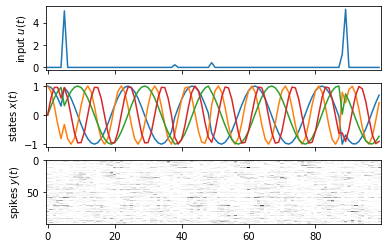

In [5]:
# Plot one trial
fig, axs = plt.subplots(3, 1, sharex=True)
trial = 2
axs[0].plot(dataset[trial]["inputs"])
axs[0].set_ylabel("input $u(t)$")
axs[1].plot(dataset[trial]["states"])
axs[1].set_ylabel("states $x(t)$")
axs[2].imshow(dataset[trial]["spikes"].T, 
              aspect="auto", interpolation="none", cmap="Greys")
axs[2].set_ylabel("spikes $y(t)$")

## Part 1: Recurrent Neural Networks in PyTorch

First, let's check out PyTorch's built-in recurrent neural network modules. Specifically, we will use a [**Gated Recurrent Unit (GRU)**](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU). 

- Like other RNNs, a GRU takes in _inputs_ and an _initial state_ to produces a sequence of states. 
- The `nn.GRU` module allows for _stacks_ of GRU layers, so the initial state is really a tensor of initial states for all layers. The output states are just those of the last layer though.

**Note**: By default, `nn.GRU` modules assume the inputs are shape $(T,B,D)$ where $T$ is the number of time steps, $B$ is the batch size, and $D$ is the input dimension.

In [6]:
# Specify the size of the GRU and the daa
input_size = 1
hidden_size = 20
num_layers = 2
num_batches = 1

rnn = nn.GRU(input_size, hidden_size, num_layers)
init_state = torch.randn(num_layers, num_batches, hidden_size)
# inputs = torch.randn(num_timesteps, num_batches, input_size)
inputs = dataset[0]["inputs"][:, None, :] # add a batch dim

with torch.set_grad_enabled(False):
    states, final_state = rnn(inputs, init_state)

In [7]:
states.shape        # sequence of states from last layer

torch.Size([100, 1, 20])

In [8]:
final_state.shape   # final state of all layers

torch.Size([2, 1, 20])

(0.0, 99.0)

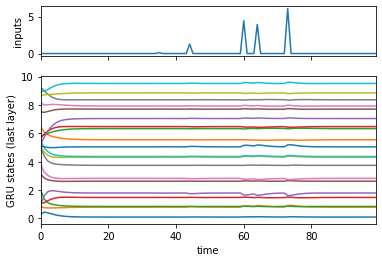

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, 
                        gridspec_kw=dict(height_ratios=[1, 3]))
axs[0].plot(inputs[:, 0, :])
axs[0].set_ylabel("inputs")
axs[1].plot(states[:, 0, :] + 0.5 * torch.arange(hidden_size))
axs[1].set_xlabel("time")
axs[1].set_ylabel("GRU states (last layer)")
axs[1].set_xlim(0, num_timesteps-1)

## Part 2: Building LFADS

Next, we construct an LFADS model. Once we've built it, we'll use it to estimate the latent oscillatory factors underlying our simulated data.

### Part 2a: Generative model

The LFADS generative model consists of two parts: inputs $\mathbf{u}_t$ and states $\mathbf{x}_t$. The state at time $t$ is a deterministic function of the previous state, the input, and the RNN weights $\theta_{\mathsf{RNN}}$,

$$
\mathbf{x}_t = h(\mathbf{x}_{t-1}, \mathbf{u}_t; \theta_{\mathsf{RNN}})
$$

Here, $h$ is a GRU. 

To sample a new sequence of latent states, we randomly sample an initial condition $\mathbf{x}_0$ and a sequence of inputs, then pass them through the RNN,

1. Sample initial condition and inputs,
    
   $$
   \begin{align*}
   \mathbf{x}_0 &\sim \mathcal{N}(0, \mathbf{I}) \\
   \mathbf{u}_t &\overset{\mathsf{iid}}{\sim} \mathcal{N}(0, \mathbf{I}) & \text{for } t &=1, \ldots, T
   \end{align*}
   $$

   and apply the RNN to get $\mathbf{x}_{1:T}$.

2. Pass the states$^*$  through a GLM to get firing rates, then sample spike counts,

   $$
   y_{t,n} \sim \mathrm{Po}(f(\mathbf{w}_n^\top \mathbf{x}_t + b_n))
   $$

   where $f$ is a rectifying nonlinearity, like the softplus or exponential funciton.

$^*$ Technically, just the states from the last layer of the GRU.

In [10]:
class LFADSGenerator(nn.Module):
    def __init__(self, 
                 num_neurons,
                 input_size,
                 num_timesteps,
                 hidden_size=20,
                 num_layers=2):
        
        super(LFADSGenerator, self).__init__()
        
        # Initialize the layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, num_neurons)
        
    def forward(self, initial_state, inputs):
        """
        initial_state: (num_layers, num_batches, hidden_size) initial state
        inputs: (num_timesteps, num_batches, input_size) tensor of inputs
        
        returns: Poisson distribution with rates of shape
            (num_timesteps, num_batches, num_neurons), 
            along with the RNN states.
        """
        states, _ = self.rnn(inputs, initial_state)
        rates = F.softplus(self.linear(states))
        return Poisson(rates), states


Text(0, 0.5, 'spikes $y(t)$')

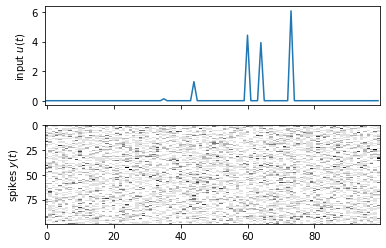

In [11]:
generator = LFADSGenerator(num_neurons=num_neurons,
                           input_size=1,
                           num_timesteps=num_timesteps,
                           hidden_size=10,
                           num_layers=1) 

# Sample spikes from the untrained generator
init_state = torch.randn((1, 1, 10))
init_lkhd, _ = generator(init_state, 20 * dataset[0]["inputs"][:, None, :])
init_spikes = init_lkhd.sample()

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(dataset[0]["inputs"])
axs[0].set_ylabel("input $u(t)$")
axs[1].imshow(init_spikes[:, 0, :].T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].set_ylabel("spikes $y(t)$")


### Part 2b: Encoder

The LFADS encoder takes in a spike train and produces a **variational posterior** distribution over the initial condition and inputs. In our implementation, we will model the posteriors as Gaussian distributions,

$$
\begin{align*}
q(\mathbf{x}_0) &= \mathcal{N}(\tilde{\boldsymbol{\mu}}_0, \tilde{\boldsymbol{\Sigma}}_0) \\
q(\mathbf{u}_t) &= \mathcal{N}(\tilde{\boldsymbol{\mu}}_t, \tilde{\boldsymbol{\Sigma}}_t)
\end{align*}
$$

**Note**: The mean $\tilde{\boldsymbol{\mu}}_0$ is not the same dimension as the other means $\tilde{\boldsymbol{\mu}}_t$ since $\mathbf{x}_0$ and $\mathbf{u}_t$ are different sizes. Same for the covariances.

The encoder **amortizes** the inference computation by learning an RNN with weights $\phi$ that can take in a spike train $\mathbf{y}_{1:T}$ and produce approximate posterior parameters $\tilde{\boldsymbol{\mu}}_{0:T}$ and $\tilde{\boldsymbol{\Sigma}}_{0:T}$, It does so via a **bidirectional** RNN: it runs a GRU both forward and backward over the data to produce an combined RNN state, which it then maps to parameters.

In [12]:
class LFADSEncoder(nn.Module):
    def __init__(self, 
                 num_neurons=20,
                 input_size=2,
                 num_timesteps=100,
                 gen_hidden_size=20,
                 gen_num_layers=2,
                 enc_hidden_size=20,
                 enc_num_layers=2):
        super(LFADSEncoder, self).__init__()
        self.num_neurons = num_neurons
        self.input_size = input_size
        self.num_timesteps = num_timesteps
        self.gen_hidden_size = gen_hidden_size
        self.gen_num_layers = gen_num_layers
        self.enc_hidden_size = enc_hidden_size
        self.enc_num_layers = enc_num_layers
        
        # Initialize the bidirection encoder GRU
        self.birnn = nn.GRU(num_neurons, enc_hidden_size, enc_num_layers, bidirectional=True)

        # Treat the initial state of the BiRNN as a learnable variational parameter
        self.init_birnn_state = nn.Parameter(torch.zeros((2 * enc_num_layers, 1, enc_hidden_size)))
        
        # Initialize linear layer for the initial state mean and var
        self.W_init_mean = nn.Linear(2 * enc_hidden_size, 
                                     gen_num_layers * gen_hidden_size)
        self.W_init_std = nn.Linear(2 * enc_hidden_size, 
                                    gen_num_layers * gen_hidden_size)
        self.W_input_mean = nn.Linear(2 * enc_hidden_size, input_size)
        self.W_input_std = nn.Linear(2 * enc_hidden_size, input_size)

    def forward(self, spikes):
        """
        spikes: (num_timesteps, num_batches, num_neurons) tensor of inputs
        returns: 
            init_dist: q(x_0), a Normal distribution
            input_dist: q(u_{1:T}), a Normal distribution
        """
        assert spikes.ndim == 3
        assert spikes.shape[0] == self.num_timesteps
        assert spikes.shape[2] == self.num_neurons
        num_batches = spikes.shape[1]

        # Run the encoder BiRNN to get states
        # states: (num_timesteps, num_batches, 2 * enc_hidden_size)
        init_birnn_state = torch.tile(self.init_birnn_state, (1, num_batches, 1))
        states, _ = self.birnn(spikes, init_birnn_state) 

        # Decode the initial state distribution (num_batches, state_size)
        # where state_size = gen_num_layers * gen_hidden_size
        init_mean = self.W_init_mean(states[0])
        init_std = F.softplus(self.W_init_std(states[0]))

        # We need to reshape the intial mean and std into the desired shape
        def _reshape(x):
            x = x.reshape(num_batches, self.gen_num_layers, self.gen_hidden_size)
            x = x.permute((1, 0, 2))
            return x
        init_dist = Normal(_reshape(init_mean), _reshape(init_std))

        # Decode the input distribution (num_timesteps, num_batches, input_size)
        input_mean = self.W_input_mean(states)
        input_std = F.softplus(self.W_input_std(states))
        input_dist = Normal(input_mean, input_std)

        return init_dist, input_dist

In [13]:
encoder = LFADSEncoder(num_neurons=num_neurons,
                       input_size=1,
                       num_timesteps=num_timesteps,
                       gen_hidden_size=10,
                       gen_num_layers=1)

In [14]:
# Make sure it runs
encoder(dataset[0]["spikes"][:, None, :])

(Normal(loc: torch.Size([1, 1, 10]), scale: torch.Size([1, 1, 10])),
 Normal(loc: torch.Size([100, 1, 1]), scale: torch.Size([100, 1, 1])))

### Part 2c: The combined LFADS model

Now that we've implemented the generative model and encoder, all that's left is to stick them together! The `LFADS` module below does exactly that. Its `forward` function takes in a spike train, passes it through the encoder to obtain a posterior distribution over initial condition and inputs, samples the posterior, and passes the result through the generator to obtain reconstructed firing rates. 

**Note:** It's important to use `rsample` to sample the variational posteriors using the **reparameterization trick**!

In [15]:
class LFADS(nn.Module):
    """LFADS is a sequential VAE with a generative model and an encoder.
    """
    def __init__(self,
                 num_neurons=20,
                 input_size=2,
                 num_timesteps=100,
                 gen_hidden_size=20,
                 gen_num_layers=2,
                 enc_hidden_size=25,
                 enc_num_layers=2):
        super(LFADS, self).__init__()
        self.num_neurons = num_neurons
        self.input_size = input_size
        self.num_timesteps = num_timesteps
        self.gen_hidden_size = gen_hidden_size
        self.gen_num_layers = gen_num_layers
        self.enc_hidden_size = enc_hidden_size
        self.enc_num_layers = enc_num_layers

        # Construct the generative model and encoder
        self.generator = LFADSGenerator(num_neurons,
                                        input_size,
                                        num_timesteps,
                                        gen_hidden_size,
                                        gen_num_layers)
        
        self.encoder = LFADSEncoder(num_neurons,
                                    input_size,
                                    num_timesteps,
                                    gen_hidden_size,
                                    gen_num_layers,
                                    enc_hidden_size,
                                    enc_num_layers)
        
    def forward(self, spikes):
        """Run the encoder to get a posterior distribution,
        then sample the posterior and pass it through the 
        generator to reconstruct the spikes.
        """
        # Compute the posterior
        q_x0, q_u = self.encoder(spikes)

        # Sample the posterior. 
        # NOTE: Use `rsample` to ensure resampling gradients work
        x0 = q_x0.rsample()
        u = q_u.rsample()

        # Reconstruct with the generator
        p_y, x = self.generator(x0, u)
        return p_y, q_x0, q_u, x
        

### Part 2d: Implement the ELBO objective

Finally, implement the ELBO,

$$
\begin{multline*}
\mathcal{L}(\theta, \phi) =
\mathbb{E}_{q_\phi(\mathbf{x}_0) q_\phi(\mathbf{u}_{1:T})} \left[ \log p_\theta(\mathbf{y}_{1:T} \mid \mathbf{x}_0, \mathbf{u}_{1:T}) \right] \\
- \mathrm{KL}(q_\phi(\mathbf{x}_0) \,\|\, p_\theta(\mathbf{x}_0)) - \sum_{t=1}^T \mathrm{KL}(q_\phi(\mathbf{u}_t) \,\|\, p_\theta(\mathbf{u}_t))
\end{multline*}
$$

In [16]:
def elbo(spikes, model):
    p_y, q_x0, q_u, _ = model(spikes)
    L = p_y.log_prob(spikes).sum()
    L -= kl_divergence(q_x0, Normal(0, 1)).sum()
    L -= kl_divergence(q_u, Normal(0, 1)).sum()
    return L


def objective(minibatch, model):
    """Compute the average negative elbo. 
    Make sure model and data are on the GPU.
    """
    model.to("cuda")
    spikes = minibatch["spikes"].permute(1, 0, 2).to("cuda")
    return -elbo(spikes, model) / spikes.numel()

In [17]:
# Make sure the code at least runs
dataloader = DataLoader(dataset, batch_size=1)
lfads = LFADS(num_neurons=num_neurons,
              input_size=1,
              num_timesteps=num_timesteps,
              gen_hidden_size=10,
              gen_num_layers=2)
objective(next(iter(dataloader)), lfads)

tensor(1.6627, device='cuda:0', grad_fn=<DivBackward0>)

## Part 3: Fit it!

First, we've written a simple function to fit the model.

In [18]:
def train_model(model, 
                dataloader, 
                objective,
                num_epochs, 
                lr=0.001):
    """Helper function to fit a model.
    """
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("Epoch")
    inner_pbar = trange(len(dataloader))
    inner_pbar.set_description("Loss")
    
    # use standard SGD with a decaying learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track the train and validation loss
    losses = []
    for epoch in range(num_epochs):
        model.train()
        inner_pbar.reset()
            
        # track the running loss over batches
        for minibatch in dataloader:
            
            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                # compute the model output and loss
                loss = objective(minibatch, model)
                
                # take the gradient and perform an sgd step
                loss.backward()
                optimizer.step()
            
            # Update running loss
            losses.append(loss)
            inner_pbar.set_description("Loss {:.4f}".format(loss))
            inner_pbar.update(1)

        # Update the progress bar
        pbar.update(1)

    return torch.tensor(losses)

In [19]:
# Run the train function.
torch.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=1)
lfads = LFADS(num_neurons=num_neurons,
              input_size=1,
              num_timesteps=num_timesteps,
              gen_hidden_size=10,
              gen_num_layers=2)
lfads.to("cuda")
losses = train_model(lfads, dataloader, objective, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss (Avg. Negative ELBO)')

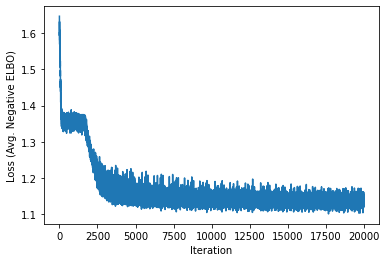

In [20]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss (Avg. Negative ELBO)")

### Part 3a: Reconstruct firing rates

As a first check, let's see if the model has learned to reconstruct the firing rates. 

In [21]:
# Reconstruct a single trial
lfads.to("cpu")
spikes = dataset[0]["spikes"]
true_inputs = dataset[0]["inputs"]

with torch.set_grad_enabled(False):
    p_y, q_x0, q_u, xs = lfads(spikes[:, None, :])

vmax = max(spikes.max(), p_y.rate.max())

Text(0.5, 1.0, 'reconstructed firing rates')

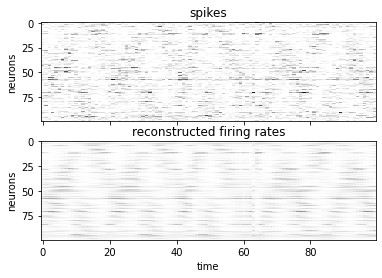

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(spikes.T, aspect="auto", interpolation="none", 
              cmap="Greys", vmin=0, vmax=vmax)
axs[0].set_ylabel("neurons")
axs[0].set_title("spikes")
axs[1].imshow(p_y.rate[:, 0, :].T, aspect="auto", interpolation="none", 
              cmap="Greys", vmin=0, vmax=vmax)
axs[1].set_ylabel("neurons")
axs[1].set_xlabel("time")
axs[1].set_title("reconstructed firing rates")

### Part 3b: Simulate from the learned model

The reconstructions above were based on **inferred inputs**. To see if the model has truly learned the oscillatory dynamics of this synthetic data, let's simulate from the model with zero inputs. We'll start it with a sample from the initial distribution output by the encoder.

Text(0.5, 1.0, 'reconstructed firing rates')

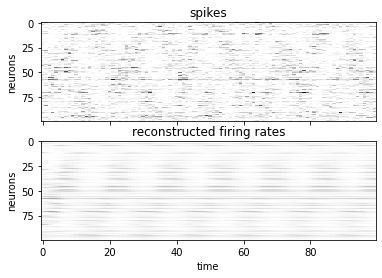

In [23]:
# Run the LFADS generator forward with zero inputs
with torch.set_grad_enabled(False):
    x0 = q_x0.mean
    inputs = torch.zeros_like(q_u.mean)
    lkhd, xs = lfads.generator(x0, inputs)
    xs = xs[:, 0, :]
    rates = lkhd.mean[:, 0, :]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(spikes.T, aspect="auto", interpolation="none", 
              cmap="Greys", vmin=0, vmax=vmax)
axs[0].set_ylabel("neurons")
axs[0].set_title("spikes")
axs[1].imshow(rates.T, aspect="auto", interpolation="none", 
              cmap="Greys", vmin=0, vmax=vmax)
axs[1].set_ylabel("neurons")
axs[1].set_xlabel("time")
axs[1].set_title("reconstructed firing rates")

It looks like the model has learned to produce some oscillatory dynamics, but they decay to zero over time. That probably means the model is compensating by learning inputs that can sustain the oscillations. Let's check out the inferred inputs.

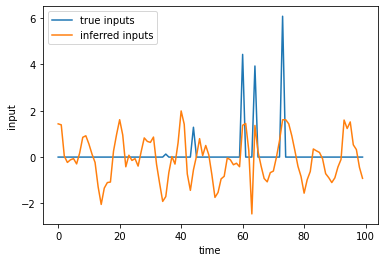

In [24]:
plt.plot(true_inputs, label="true inputs")
plt.plot(q_u.mean[:, 0, 0], label="inferred inputs")
plt.xlabel("time")
plt.ylabel("input")
plt.legend()

Indeed, it looks like the encoder produces large input spikes at times when the true inputs are present, but it also has oscillatory dynamics throughout the trial that really should have been captured by the RNN.

**Question:** What does this finding suggest about how you should interpret the inferred inputs?

### Part 3c: Looking at the inferred states

In LFADS, the firing rates are rectified linear functions of the underlying RNN states. We can get a sense for how high-dimensional those states are by looking at the SVD of the output weights. 

Text(0, 0.5, 'singular value')

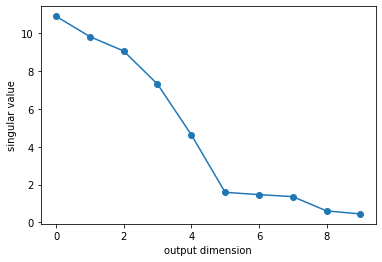

In [25]:
with torch.set_grad_enabled(False):
    U, S, Vh = torch.linalg.svd(lfads.generator.linear.weight)

plt.plot(S, '-o')
plt.xlabel("output dimension")
plt.ylabel("singular value")

Indeed, it looks like the model has learned that firing rates are low dimensional. Only 5 singular values stand out from the rest. In this synthetic data, recall that the firing rates are truly 4 dimensional (they are linear functions of the sine and cosine of two oscillators). The model isn't far off!

Next, let's plot the generated RNN states projected onto these 5 **output dimensions**.

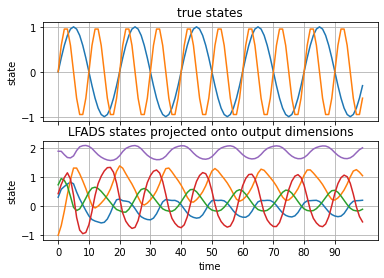

In [30]:
xs_proj = xs @ Vh[:5].T
fig, axs = plt.subplots(2, 1, sharex=True)
ts = torch.arange(num_timesteps)
axs[0].plot(ts, torch.sin(rate0 * ts))
axs[0].plot(ts, torch.sin(rate1 * ts))
axs[0].set_ylabel("state")
axs[0].set_title("true states")
axs[0].grid(True)

axs[1].plot(xs_proj)
axs[1].set_xlabel("time")
axs[1].set_xticks(torch.arange(0, num_timesteps, 10))
axs[1].set_ylabel("state")
axs[1].set_title("LFADS states projected onto output dimensions")
axs[1].grid(True)

These seem to have captured some oscillations! It's not so obvious they're the right frequencies, but close...ish.

## Conclusion

From here, you could further unpack the learned generator to study its fixed points and the linearized dynamics around them. Such analyses can shed light on how the RNN works, at least in the language of linear dynamics and fixed points. This perspective on reverse engineering neural systems is sometimes referred to as **computation through dynamics** [(Vyas et al, 2020)](https://www.annualreviews.org/doi/abs/10.1146/annurev-neuro-092619-094115).

Note that the model above is a rather simplified version of LFADS. The [standard LFADS implementation](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/LFADS%20Tutorial.ipynb) has a more complex encoder that uses the generator RNN in the posterior computation. There are also many more tricks to improve training performance. That said, this notebook should give you the gist of how this class of models works under the hood!


References:

Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual review of neuroscience 43 (2020): 249-275.
